In [1]:
import numpy as np 
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

from scipy.io import loadmat
from itertools import product 
from math import ceil, floor, exp
from copy import deepcopy 

SEED = 42
np.random.seed(SEED)

In [2]:
def plot_statistics(S, I, R, new_I, V = None, new_V = None):
    plt.plot(range(N_WEEKS), np.mean(I,axis = 0), label = "Weekly I")
    plt.plot(range(N_WEEKS), np.mean(S,axis = 0), label = "Weekly S")
    plt.plot(range(N_WEEKS), np.mean(R,axis = 0), label = "Weekly R")
    if V is not None: 
            plt.plot(range(N_WEEKS), np.mean(V, axis = 0), label = "Weekly V")
    plt.xlabel("Week")
    plt.ylabel("Average statistics")
    plt.title(f"Average SIR statistics over {N_WEEKS} weeks and {N_SIMULATIONS} simulations")
    plt.legend()
    plt.show()

    plt.plot(range(N_WEEKS), np.mean(new_I,axis = 0), label = "Weekly new I")
    if V is not None:
        plt.plot(range(N_WEEKS), new_V, label = "Weekly new V")
        plt.title(f"Average new infections and vaccines over {N_WEEKS} weeks and {N_SIMULATIONS} simulations")
        plt.ylabel("Average new Infected and Vaccinated")
    else:
        plt.title(f"Average new infections over {N_WEEKS} weeks and {N_SIMULATIONS} simulations")
        plt.ylabel("Average new Infected")
    plt.xlabel("Week")
    plt.legend()
    plt.show()
    
    return 

# PRELIMINARY PARTS (1)

Simulate 100 times a SIR epidemics using discrete Markov Chains on a symmetric k-regular udirected graph, with 500 nodes and k = 4. The simulation happens for 15 weeks. 
Given $\beta \in [0,1]$ the probability that the infection is spread from an infected individual to a susceptible one, assuming that $s \in S$ has $m$ infected neighbors, then the probability that $s$ becomes infected is:\
$ P(X_i(t+1) = I| X_i(t) = S, \sum_{j\in\mathcal{V}}W_{ij}\delta^I_{X_j(t)} = m) = 1-(1-\beta)^m$\
Whereas, given an infected individual and $\rho \in [0,1]$ the probability that $i \in I$ recovers, then:\
$P(X_i(t+1) = R | X_i(t) = I) = \rho$\
\
Plot:\
1- The average number of newly infected individuals each week given 100 simulations\
2- The average total number of susceptible, infected, and recovered individuals at each week given 100 simulations

In [3]:
def find_infected_neighbors(node, G, I):
    return len([neighbor for neighbor in G.neighbors(node) if neighbor in I])

In [4]:
def SIR_pandemic(G, NODES, N_SIMULATIONS, N_WEEKS, BETA, RO, INITIAL_INFECTED=10):    
    #initial configuration
    simulation_new_I = []
    simulation_I = []
    simulation_S= []
    simulation_R = []

    #perform simulation
    for simulation in range(N_SIMULATIONS):
        #single simulation configuration
        weekly_new_I = []
        weekly_I = []
        weekly_S =[]
        weekly_R = []
        
        R = set()
        I = set(np.random.choice(NODES, INITIAL_INFECTED, replace = False))
    
        #Markov Chain
        for week in range(N_WEEKS):
            new_I = set()
            new_R = set()
            for node in range(NODES):
                #if susceptible it becomes a new infected node with probability (1-beta)^m
                if node not in R and node not in I and np.random.random() <= 1-(1-BETA)**find_infected_neighbors(node, G, I):
                    new_I.add(node)
                #if infected it becomes a new recovered node with probability p 
                if node in I and np.random.random() <= RO:
                    new_R.add(node)
            #update infected and recovered sets
            R = R | new_R
            I = I - new_R | new_I
            
            #update weekly statistics
            weekly_new_I.append(len(new_I))
            weekly_I.append(len(I))
            weekly_R.append(len(R))
            weekly_S.append(NODES-len(I)-len(R))

        #update simulation statistics
        simulation_new_I.append(deepcopy(weekly_new_I))
        simulation_I.append(deepcopy(weekly_I))
        simulation_S.append(deepcopy(weekly_S))
        simulation_R.append(deepcopy(weekly_R))
        
    return simulation_S, simulation_I, simulation_R, simulation_new_I

In [5]:
NODES = 500
K = 4
BETA = .3
RO = .7
N_SIMULATIONS = 100
N_WEEKS = 15

In [6]:
def get_neighbors_exercise1(node, NODES):
    return [(node + i)%NODES for i in range(1,3)] +  [(node - i)%NODES for i in range(1,3)]

In [7]:
#construct the graph
G = nx.DiGraph()
for node in range(NODES):
    edges = [(node, neighbor) for neighbor in get_neighbors_exercise1(node, NODES)]
    G.add_edges_from(edges)


In [8]:
#run the pandemic
S, I, R, new_I= SIR_pandemic(G, NODES, N_SIMULATIONS, N_WEEKS, BETA, RO)
new_I = np.array(new_I)
I = np.array(I)
S = np.array(S)
R = np.array(R)

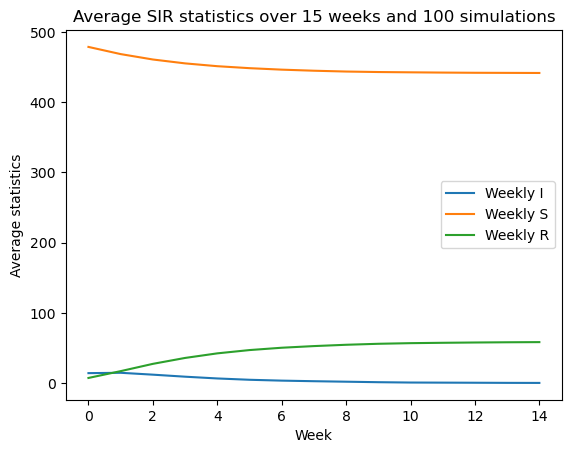

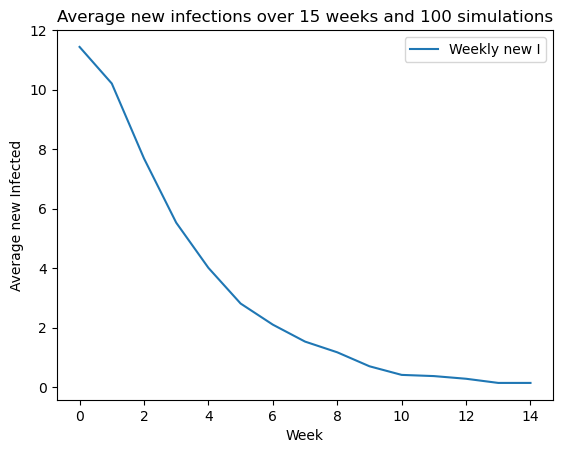

In [9]:
plot_statistics(S,I,R,new_I)

# PRELIMINARY PARTS (2)

Gnerate a random graph according to the preferential attachment model. Starting from a complete graph of $k_0 = k+1$ nodes, at each iteration, a connect a new incoming nodes using $c = k/2$ undirected edges to the already existing graph. The algorithm should decide the nodes for the connection according to the following probability:\
$P(W_{n_t,i} = W_{i,n_t} = 1 | G_{t-1} = (V_{t-1}, \varepsilon_{t-1})) = \frac{\omega_i(t-1)}{\sum_{j \in V_{t-1}}\omega_j(t-1)}$
\
The goal is to se the model to generate a  graph of size greather than 900 and such that at the end the average degree of the nodes is $k$.  

In [10]:
def preferential_attachment(K, GOAL):
    '''Create a graph according to the preferental attachment model'''
    G = nx.complete_graph(K+1)
    #iterate untill at least 900 nodes are added
    while len(G.nodes()) < GOAL:
        #compute degrees
        w = np.sum(nx.adjacency_matrix(G), axis = 1)/np.sum(nx.adjacency_matrix(G))
        w = np.ravel(w)

        #K is even  
        if K%2 == 0: 
            c = int(K/2)
        #if K is odd alternate between ceil and floor
        elif K%2!=0 and len(G.nodes())%2 == 0:
            c = ceil(K/2)
        else:
            c = floor(K/2)

        #choose nodes to connect 
        chosen_nodes = np.random.choice(G.nodes(), size = c, replace = False, p=w)
        #create new node and add it to the graph
        new_node = len(G.nodes())
        G.add_edges_from([(new_node, neighbor) for neighbor in chosen_nodes])
    
    return G

In [11]:
k = 4
NODES = 900
G = preferential_attachment(k, NODES)
print(f"Mean degree k is {np.mean(list(dict(G.degree()).values()))}")

C:\Users\aless\AppData\Local\Temp\ipykernel_18092\2863859495.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w = np.sum(nx.adjacency_matrix(G), axis = 1)/np.sum(nx.adjacency_matrix(G))


Mean degree k is 4.0



# SIMULATE A PANDEMIC WITHOUT VACCINATION

Using the methods develped in the preliminary parts, simulate a SIR epidemic on a random graph.\
Parameters:\
Number of nodes = 500 \
$\beta$ = .3 \
$\rho$ = .7 \
$k$ = 6 \
Number of weeks = 15 \
\
Plot:\
1- The average number of newly infected individuals each week given 100 simulations\
2- The average total number of susceptible, infected, and recovered individuals at each week given 100 simulations

In [12]:
BETA = 0.3
RO = 0.7
K = 6
NODES = 500
N_WEEKS = 15
N_SIMULATIONS = 100

In [13]:
G = preferential_attachment(K, NODES)

C:\Users\aless\AppData\Local\Temp\ipykernel_18092\2863859495.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w = np.sum(nx.adjacency_matrix(G), axis = 1)/np.sum(nx.adjacency_matrix(G))


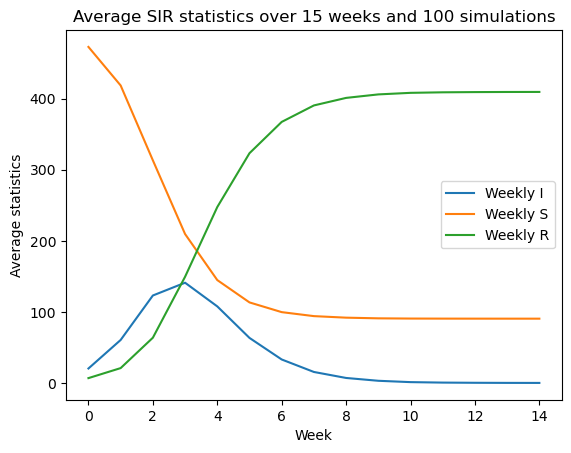

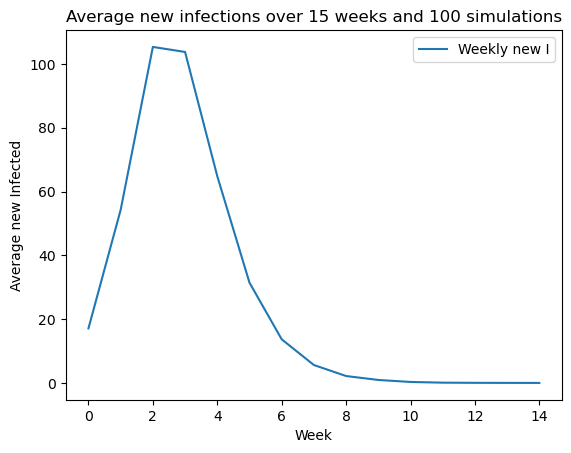

In [14]:
S,I,R, new_I = SIR_pandemic(G, NODES, N_SIMULATIONS, N_WEEKS, BETA, RO)
new_I = np.array(new_I)
I = np.array(I)
S = np.array(S)
R = np.array(R)
plot_statistics(S, I, R, new_I)

# SIMULATE A PANDEMIC WITH VACCINATION

Suppose to run an epidemics with vaccination. $V_{rates}$ describe the percentage over the whole population that is vaccinated at week $i$. Assume the vaccination takes effect immediately once the vaccine it given and that individuals from all SIR compartments can be vaccinated. \
The simulation happens as follows: at the beginning of each week the vacinated individuals are chosen acording to $V_{rates}$, then on the remaining individuals the SIR model is performed. The graph is constracted with the preferential attachment model.\
Number of nodes = 500 \
$\beta$ = .3 \
$\rho$ = .7 \
$k$ = 6 \
Number of weeks = 15 \
\
Plot:\
1- The average number of newly infected and newly vaccinated individuals each week given 100 simulations\
2- The average total number of susceptible, infected, vaccinated, and recovered individuals at each week given 100 simulations

In [15]:
BETA = .3
RO = .7
K = 6
NODES = 500
N_WEEKS = 15
N_SIMULATIONS = 100
INIT_VACC= 0
INIT_INF= 10

G = preferential_attachment(K, NODES)

C:\Users\aless\AppData\Local\Temp\ipykernel_18092\2863859495.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w = np.sum(nx.adjacency_matrix(G), axis = 1)/np.sum(nx.adjacency_matrix(G))


In [16]:
#assuming 0 individuals have been vaccinated when starting the simulation
V_rates = [0] + [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
V_over_15_weeks = [int((V_rates[i]-V_rates[i-1])*NODES/100) for i in range(1, N_WEEKS+1)]

In [17]:
def SIR_pandemic_vaccines(G, NODES, N_SIMULATIONS, N_WEEKS, BETA, RO, V_WEEK, INIT_INFECTED= 10, INIT_VACCINES = 0):
    '''Simulate a discrete Markow chain on a SIR model with vaccination'''
    node_set = set(G.nodes())

    #store every simulation
    simulation_new_I = []
    simulation_I = []
    simulation_S= []
    simulation_R = []
    simulation_V = []


    #perform simulation
    for simulation in range(N_SIMULATIONS):
        
        #randomly choose INIT_VACC vaccinated individuals
        V = set(np.random.choice(NODES, INIT_VACCINES, replace = False))
        #randomly choose INIT_INF infected individuals from the remaining
        I = set(np.random.choice(list(node_set - V), INIT_INFECTED, replace = False))
        #all other individuals are susceptibles
        S = set(node_set) - I - V
        R = set()
        available_population = node_set-V
        
        #store weekly updates
        weekly_new_I = []
        weekly_I = []
        weekly_S =[]
        weekly_R = []
        weekly_V = []

        #Markov Chain
        for week in range(N_WEEKS):
            new_I = set()
            new_R = set()

            #Vaccination
            chosen_nodes = set(np.random.choice(list(available_population), size = V_WEEK[week], replace=False))
            
            #Update compartments after vaccination 
            V = V | chosen_nodes
            I = I - chosen_nodes
            R = R - chosen_nodes
            S = S - chosen_nodes

            #Infection 
            for node in range(NODES):
                #if susceptible it becomes a new infected node with probability (1-beta)^m
                if node in S and np.random.random() <= 1-(1-BETA)**find_infected_neighbors(node, G, I):
                    new_I.add(node)
                #if infected it becomes a new recovered node with probability p 
                if node in I and np.random.random() <= RO:
                    new_R.add(node)

            #update compartments and number of available individuals for vaccination
            S = S - new_I
            R = R | new_R
            I = I - new_R | new_I
            available_population = R|I|S

            #update weekly statistics
            weekly_new_I.append(len(new_I))
            weekly_I.append(len(I))
            weekly_R.append(len(R))
            weekly_S.append(len(S))
            weekly_V.append(len(V))

        #update simulation statistics
        simulation_new_I.append(deepcopy(weekly_new_I))
        simulation_I.append(deepcopy(weekly_I))
        simulation_S.append(deepcopy(weekly_S))
        simulation_R.append(deepcopy(weekly_R))
        simulation_V.append(deepcopy(weekly_V))

    return simulation_S, simulation_I, simulation_R, simulation_V, simulation_new_I

In [18]:
S, I, R, V, new_I = SIR_pandemic_vaccines(G, NODES, N_SIMULATIONS, N_WEEKS, BETA, RO, V_over_15_weeks)
new_I = np.array(new_I)
I = np.array(I)
S = np.array(S)
R = np.array(R)
v = np.array(V)

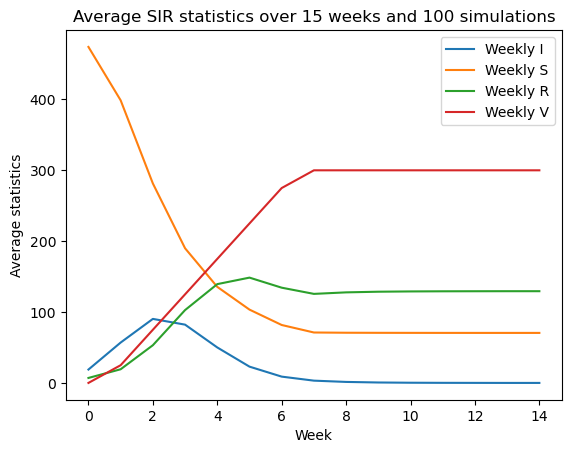

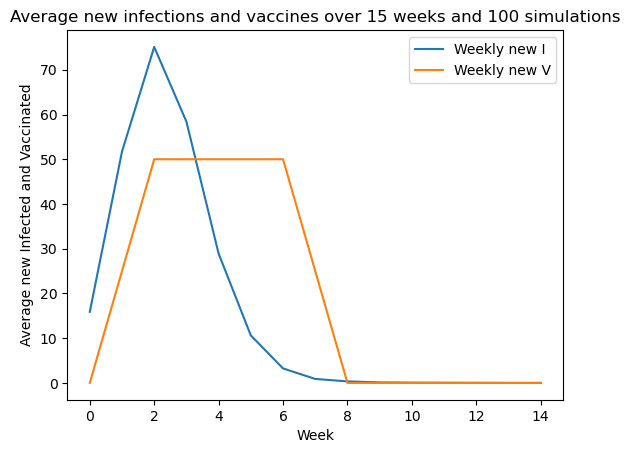

In [19]:
plot_statistics(S, I, R, new_I, V, V_over_15_weeks)

# PANDEMIC H1N1 SWEDEN 2009

In [20]:
N_WEEKS = 15
NODES = 934
N_SIMULATIONS = 10
MAX_ITERATIONS = 100

#true number of infections
I0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
#initial number of infected individuals
INIT_INFECTED = I0[0]

In [21]:
V_rates = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]

#initial number of vaccinated individuals (before the simulation starts)
INIT_VACCINES = int(V_rates[0]*NODES/100)

#compute for 15 weeks the total number of infected individuals
V_over_15_weeks = [int((V_rates[i]-V_rates[i-1])*NODES/100) for i in range(1, N_WEEKS+1)]

In [22]:
def compute_RMSE(I0, I):
    return (1/15*np.sum((I-I0[1:])**2))**.5

In [23]:
#initial guess 
K = 10
BETA = .3
RO = .6
delta_K = 1
delta_BETA = .1
delta_RO = .1

#initial overall best
overall_parameters = best_iter_params = [K, BETA, RO]

for iteration in range(MAX_ITERATIONS):
    K, BETA, RO = overall_parameters
  
    #create the combinations of values
    parameters = product([K, K+delta_K, K-delta_K], [BETA, BETA+delta_BETA, BETA-delta_BETA],
                         [RO, RO+delta_RO, RO-delta_RO])
    
    #set to infnity the best RSME
    best_iter_RMSE = float("inf")
    
    #iterate over cartesian product (27 configurations)
    for k, beta, ro in parameters:         
        G = preferential_attachment(k, NODES)
        _, _, _, _, new_I = SIR_pandemic_vaccines(G, NODES, 
                                                         N_SIMULATIONS, 
                                                         N_WEEKS, beta, ro, 
                                                         V_over_15_weeks, 
                                                         INIT_INFECTED = INIT_INFECTED, 
                                                         INIT_VACCINES = INIT_VACCINES)
        
        current_RMSE = compute_RMSE(I0, np.mean(new_I, axis=0))
        #save best among cartesian product
        if current_RMSE < best_iter_RMSE:
            best_iter_params = (k, beta, ro)
            best_iter_RMSE = current_RMSE
    
    #if the best parameters did not change with the overall 
    if best_iter_params == overall_parameters:
        break      
    
    #if the best parameters returned a better RMSE, update overall
    #if best_iter_RMSE < overall_RMSE:
    overall_parameters = best_iter_params

    
print(f"Ending at iteration {iteration} with {overall_parameters}")

C:\Users\aless\AppData\Local\Temp\ipykernel_18092\2863859495.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w = np.sum(nx.adjacency_matrix(G), axis = 1)/np.sum(nx.adjacency_matrix(G))


Ending at iteration 1 with (9, 0.19999999999999998, 0.6)


In [24]:
K, BETA, RO = overall_parameters
G = preferential_attachment(K, NODES)
S, I, R, V, new_I= SIR_pandemic_vaccines(G, NODES, 
                                                 100, 
                                                 N_WEEKS, BETA, RO, 
                                                 V_over_15_weeks, 
                                                 INIT_INFECTED = INIT_INFECTED, 
                                                 INIT_VACCINES = INIT_VACCINES)

C:\Users\aless\AppData\Local\Temp\ipykernel_18092\2863859495.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w = np.sum(nx.adjacency_matrix(G), axis = 1)/np.sum(nx.adjacency_matrix(G))


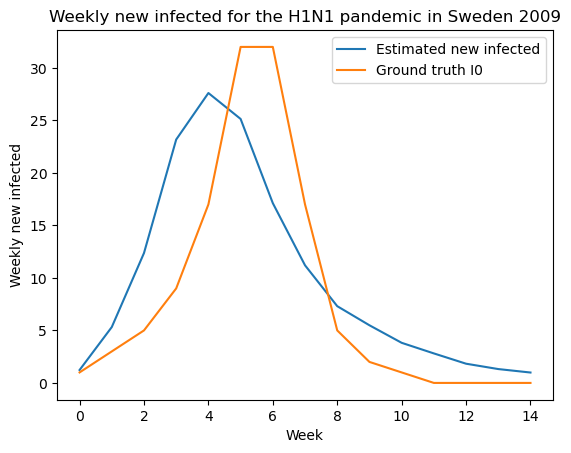

In [25]:
plt.plot(range(N_WEEKS), np.mean(new_I,axis = 0), label = "Estimated new infected")
plt.plot(range(N_WEEKS), I0[1:], label = "Ground truth I0")
plt.legend()
plt.xlabel("Week")
plt.ylabel("Weekly new infected")
plt.title("Weekly new infected for the H1N1 pandemic in Sweden 2009")
plt.show()

# COLORING (A)



Aim: assign a color to each node in an undirected graph uch that any neighbor has the same color.\
Construct a linear graph with 10 nodes and suppose the set of possible states (i.e., the set of possible colors) is C = {red, green}. Suppose all nodes start with $X_i(t)$ = red.\
For every iteration $t$:\
1- A node $I(t)$ is randomly chosen uniformly at random and updates its color\
2- The new color is chosen with probability:\
$P(X_i(t+1)=a| X(t), I(t)=i) = \frac{e^{-\eta(t)\sum_j c(a, X_j(t))}}{\sum_{s\in C}e^{-\eta(t)\sum_jW_{ij}c(s,X_j(t))}}$\
Where the cost function $c(, x_j(t))$ is 1 if $X_j(t) = s$ otherwise 0 and $\eta(t) = t/100$. \
The potential function considered is:\
$U(t) = 0.5\sum_{i,j \in V} W_{ij}c(X_i(t), X_j(t))$\
and the solution in found when the potential is zero, hence there are no conflicting nodes. 
Simulate the dynamics.

In [26]:
def get_cost_a(goal_state, state_array, neighbors):
    '''Given a state (i.e., a color), computed Sum_j Wij c(state, neighbor_state)'''
    #the cost is one when the neighboring state is the state we want to achieve
    return len([1 for n in neighbors if state_array[n]==goal_state])

def compute_potential(G, state_array, get_cost):
    '''Compute potential function U(t)'''
    total = 0
    for node in G.nodes():
        total += get_cost(state_array[node], state_array, list(G.neighbors(node)))
    return total/2

def compute_probability_matrix(G, node, N_COLORS, state_array, nt, get_cost):
    '''Returns the probability of a node to change its color'''
    neighbors = list(G.neighbors(node))
    #for every color compute the probability of transitioning to that color
    costs = - nt * np.array([get_cost(color, state_array, neighbors) for color in range(N_COLORS)])
    costs = np.exp(costs)
    return costs/np.sum(costs)
            

In [27]:
def coloring(G, N_COLORS, MAX_ITERATIONS, state_array, cost_function, nt_function, min_potential = None):
    '''Coloring function'''
    time = 1
    potential_array = []
    
    for iteraton in range(MAX_ITERATIONS):
        #randomly choose a node
        node = np.random.choice(G.nodes)
        #nt function 
        nt = nt_function(time)
        #compute new state
        probabilities = compute_probability_matrix(G, node, N_COLORS, state_array, nt, cost_function)
        new_state = np.random.choice(range(N_COLORS), p=probabilities)
        #update_state
        state_array[node] = new_state

        #compute potential_function
        potential = compute_potential(G, state_array, cost_function)
        potential_array.append(potential)
        if potential == 0:
            break

        if min_potential is not None:
            if potential<min_potential:
                min_potential = potential
                best_configuration = deepcopy(state_array)

        time += 1
    
    if min_potential is None:        
        return time, potential_array

    else:
        return time, potential_array, min_potential, best_configuration

In [28]:
colors= ['red', 'green']
N_COLORS = len(colors)
MAX_ITERATIONS = 250
NODES = 10
time = 0
state_array = np.zeros(NODES)
potential_array = []

In [29]:
#create line graph
edges = [(i, i+1) for i in range(NODES-1)]
G = nx.Graph()
G.add_edges_from(edges)

In [30]:
time, potential_array = coloring(G, N_COLORS, MAX_ITERATIONS, state_array, get_cost_a, nt_function = lambda t: t/100)    
print(f"Simulation took {time} steps")

Simulation took 196 steps


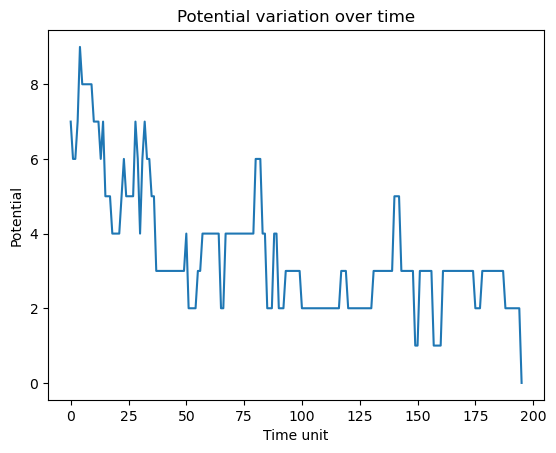

In [31]:
plt.plot(range(time), potential_array)
plt.xlabel("Time unit")
plt.ylabel("Potential")
plt.title("Potential variation over time")
plt.show()

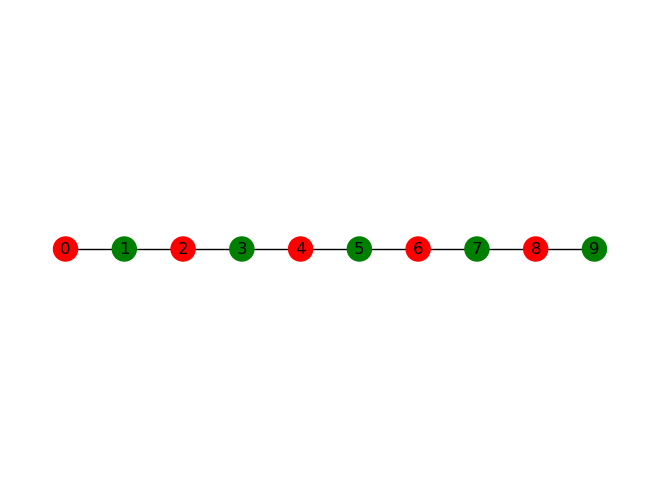

In [32]:
color_list = []
position = dict()

for node in range(NODES):
    color_list.append(colors[int(state_array[node])])
    position[node] = (node, 0)

nx.draw(G, with_labels =True, node_color = color_list, pos = position)

# COLORING (B)

In file coord.mat and in file wifi.mat are present, respectively, the cooridnated an the adjacency matrix of a Graph. The nodes represent routers, whereas the edges represent the possibility for two routers to intefere with each other. 
We use the same coloring algorithm, as well as the same potential function $U(t)$ as in COLORING(A). \
The cost here changes:\
$c(s, X_j(t)) = 2 ~ if ~X_j(t) = s$\
$c(s, X_j(t)) = 1 ~if ~|X_j(t)-s|=1$\
$c(s, X_j(t)) = 0 ~otherwise$\
$c(s, X_j(t))$ aims at giving to two neighbors two colors that distances at least 2 in the color vector. Colors here rpresent bandwidths.
\
Simulte the coloring multiple times, plot the potential, show that it never reaches 0 and comment on it. 

In [33]:
def get_cost_b(goal_state, state_array, neighbors):
    '''Given a state (i.e., a color), computed Sum_j Wij c(state, neighbor_state)'''
    return np.sum([max(2-abs(state_array[n]-goal_state), 0) for n in neighbors])


In [34]:
colors = ["red", "green", "blue", "yellow", "magenta", "cyan", "white", "black"]
N_COLORS = len(colors)
N_RUNS = 3
MAX_ITERATIONS = 1000

In [35]:
coordinates = np.loadtxt("coords.mat")
adjacency_matrix = np.loadtxt("wifi.mat")
NODES = len(adjacency_matrix)

In [36]:
#construct the graph
G = nx.Graph()
edge_list = []

for node in range(NODES):
    G.add_node(node)
    for neighbor in range(NODES):
        if adjacency_matrix[node][neighbor]:
            edge_list.append((node, neighbor))
            
G.add_edges_from(set(edge_list))

In [37]:
potential_functions = []
global_min = float("inf")

for run in range(N_RUNS):
    state_array = np.zeros(NODES)
    time, potential_simulation, min_simulation, best_simulation = coloring(G, 
                                                                           N_COLORS, 
                                                                           MAX_ITERATIONS,
                                                                           state_array, 
                                                                           get_cost_b, 
                                                                           nt_function = lambda time: time/100,
                                                                           min_potential = float("inf"))
    #adjust the best simulation over the runs 
    if min_simulation < global_min:
        global_min = min_simulation
        best_configuration = best_simulation
        
    potential_functions.append(deepcopy(potential_simulation))

print(f"Minimum potential obtained over {N_RUNS} runs is: {global_min}")

Minimum potential obtained over 3 runs is: 4.0


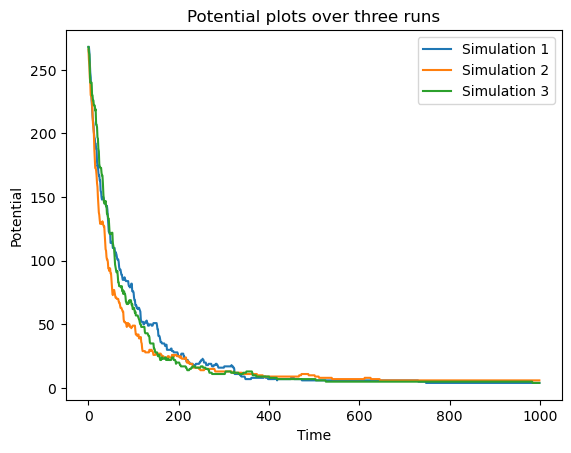

In [38]:
for run, pot in enumerate(potential_functions):
    plt.plot(range(MAX_ITERATIONS), pot, label = f"Simulation {run +1}")

    
plt.xlabel("Time")
plt.ylabel("Potential")
plt.title("Potential plots over three runs")
plt.legend()
plt.show()

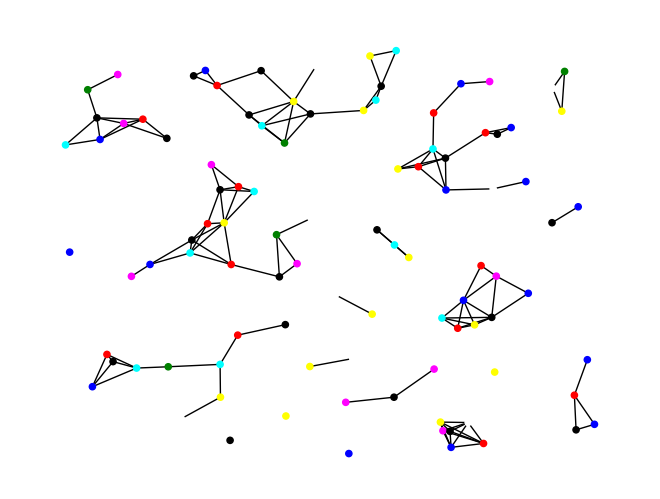

In [39]:
color_list = []
position = dict()

for node in range(NODES):
    color_list.append(colors[int(best_configuration[node])])
    position[node] = tuple(coordinates[node])

nx.draw(G, with_labels =False, node_size = 20, node_color = color_list, pos = position)

The problem with the potential hehre is that we have two complete subgraphs with 5 and 6 nodes, however we only have at most 4 colors that distance more than 2 in the color vector. Therefore there is no combination of colors in the graph that make all costs be 0, consequently the potential never reaches 0.

# OPTIONAL COLORING

See how multiple $\eta(t)$ functions behave. 

In [40]:
global_min = float("inf")

state_array = np.zeros(NODES)
time, potential_simulation_n100, min_simulation, best_simulation = coloring(G, 
                                                                       N_COLORS, 
                                                                       MAX_ITERATIONS,
                                                                       state_array, 
                                                                       get_cost_b, 
                                                                       nt_function = lambda time: 100,
                                                                       min_potential = float("inf"))


print(f"Minimum potential obtained over {N_RUNS} runs is: {min_simulation}")

Minimum potential obtained over 3 runs is: 4.0


In [41]:
global_min = float("inf")

state_array = np.zeros(NODES)
time, potential_simulation_n05, min_simulation, best_simulation = coloring(G, 
                                                                       N_COLORS, 
                                                                       MAX_ITERATIONS,
                                                                       state_array, 
                                                                       get_cost_b, 
                                                                       nt_function = lambda time: .5,
                                                                       min_potential = float("inf"))


print(f"Minimum potential obtained over {N_RUNS} runs is: {min_simulation}")

Minimum potential obtained over 3 runs is: 28.0


In [42]:
global_min = float("inf")

state_array = np.zeros(NODES)
time, potential_simulation_sqrt, min_simulation, best_simulation = coloring(G, 
                                                                       N_COLORS, 
                                                                       MAX_ITERATIONS,
                                                                       state_array, 
                                                                       get_cost_b, 
                                                                       nt_function = lambda time: np.sqrt(time),
                                                                       min_potential = float("inf"))


print(f"Minimum potential obtained over {N_RUNS} runs is: {min_simulation}")

Minimum potential obtained over 3 runs is: 4.0


In [43]:
global_min = float("inf")

state_array = np.zeros(NODES)
time, potential_simulation_log, min_simulation, best_simulation = coloring(G, 
                                                                       N_COLORS, 
                                                                       MAX_ITERATIONS,
                                                                       state_array, 
                                                                       get_cost_b, 
                                                                       nt_function = lambda time: np.log(time),
                                                                       min_potential = float("inf"))


print(f"Minimum potential obtained over {N_RUNS} runs is: {min_simulation}")

Minimum potential obtained over 3 runs is: 4.0


In [44]:
global_min = float("inf")

state_array = np.zeros(NODES)
time, potential_simulation_slow, min_simulation, best_simulation = coloring(G, 
                                                                       N_COLORS, 
                                                                       MAX_ITERATIONS,
                                                                       state_array, 
                                                                       get_cost_b, 
                                                                       nt_function = lambda time: time/10000,
                                                                       min_potential = float("inf"))


print(f"Minimum potential obtained over {N_RUNS} runs is: {min_simulation}")

Minimum potential obtained over 3 runs is: 46.0


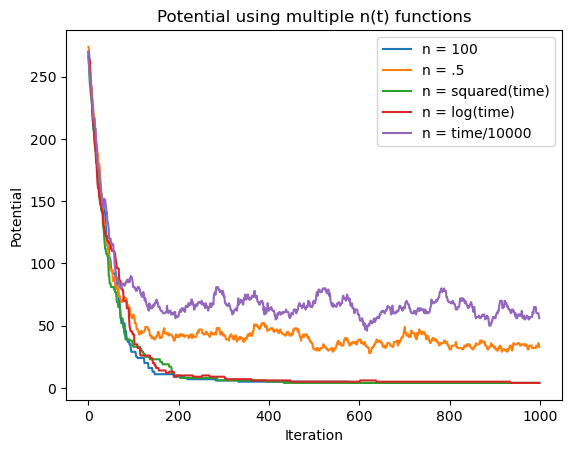

In [45]:
plt.plot(range(MAX_ITERATIONS), potential_simulation_n100, label = "n = 100")
plt.plot(range(MAX_ITERATIONS), potential_simulation_n05, label = "n = .5")
plt.plot(range(MAX_ITERATIONS), potential_simulation_sqrt, label = "n = squared(time)")
plt.plot(range(MAX_ITERATIONS), potential_simulation_log, label = "n = log(time)")
plt.plot(range(MAX_ITERATIONS), potential_simulation_slow, label = "n = time/10000")

plt.xlabel("Iteration")
plt.ylabel("Potential")
plt.title("Potential using multiple n(t) functions")
plt.legend()

plt.show()